##  Basic examples: getting started

In the `data` folder is provided a continuum subtracted image (I haven't removed the skylines) of the HD163296 jet taken in 2017 with the [MUSE](http://muse-vlt.eu/science/) instrument on the Very Large Telescope (VLT) operated by the European Southern Observatory (ESO) under Program ID 099.C-0214(A). The PV-slice was generated using [`pvextractor`](https://github.com/keflavich/pvextractor) (which is a super useful tool!) and spans a range of $6000-6800\dot{\rm A}$. We will look at the $\rm{[OI]}\lambda6300$ emission and the $\rm H\alpha$ emission.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from telassar import PVSlice
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file = "../data/hd163296_pvslice.fits"
pvdiag = PVSlice(file)

pvdiag.info()

[INFO] PVSlice (../data/hd163296_pvslice.fits)
[INFO] Data shape: (376 x 641) (arcsec, Angstrom)
[INFO] Spatial Offset: min: -37.6" max: 37.4" step: 0.200"
[INFO] Spectral extent: min 6000.00 Angstrom max: 6800.00 Angstrom step: 1.250 Angstrom


<IPython.core.display.Javascript object>


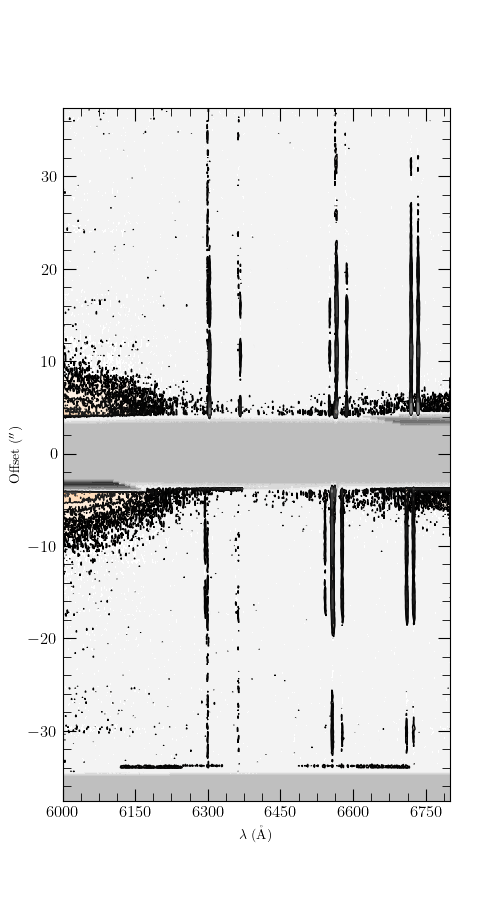

<AxesSubplot:xlabel='$\\lambda$ ($\\mathrm{\\mathring{A}}$)', ylabel='Offset ($\\mathrm{{}^{\\prime\\prime}}$)'>

In [4]:
%matplotlib notebook

# make a simple plot
pvdiag.plot_contours()

Some customization of the plot can be done. For example, we can trim the image to get a window around the $\rm{[OI]}\lambda6300$ emission line with `spectral_window()`, then call the `radial_velocity()` method to get a rough estimate of the velocity ranges and format x-axis accordingly. By default, `spectral_window()` assumes pixel units, so if we don't want that we can specify the units.

Additionally, if a systemic velocity is known for an object, you can specify the `vcorr` parameter in the `radial_velocity()` function. For this object, we will correct for the systemic motion of the star with $v_{\rm sys}$=5. km/s, with respect to the LSR (Qi et al., 2011, ApJ, 740, 84, [doi:10.1088/0004-637X/740/2/84](https://ui.adsabs.harvard.edu/link_gateway/2011ApJ...740...84Q/doi:10.1088/0004-637X/740/2/84)).

In [5]:
# OI6300
oi6300 = pvdiag.spectral_window(vmin=6288, vmax=6312, unit='angstrom')

lbda1, lbda2 = oi6300.velwave.get_range()
vsys = 5.8

oi_vrad = oi6300.radial_velocity(ref='OI6300', lbdas=[lbda1, lbda2], vcorr=vsys)

Now, let's inspect it. With the `plot_contours()` method we can specify several parameters:

In [6]:
help(oi6300.plot_contours)

Help on method plot_contours in module telassar.pvslice:

plot_contours(figure=None, place=None, sigma=None, mask=None, levels1=None, levels2=None, cmaps=None, fig_kws=None, plt_kws=None, emline=None) method of telassar.pvslice.PVSlice instance
    Generate a contour plot of the data. Useful for jet visualization!
    
    Parameters
    -----------
    figure : None or `matplotlib.Figure` instance
        if you have a figure instance you want to send this to, specify it
    sigma : None or float
        the basis for generating levels. a 3sigma value indicates detection
        of a source, we abbreviate it here to just sigma
    place : int
        if you have multiple subplot axes, you can send the image to one
    mask : `np.ma.masked_array`
        if you want to specify a mask to send when computing the background
        levels, do it here
    levels1 : None or `np.ndarray` or list
        the contour levels for the jets
    levels2 : None or `np.ndarray` or list
        the co

So there's an attempt here at making a fairly easily customizable plot. Anything not specified by the user will be estimated by the plotter. The standard contour levels honestly aren't the best, and I haven't figured out a good way to handle them. But, we can define our own, so let's pass a few keywords and try them out.

<IPython.core.display.Javascript object>


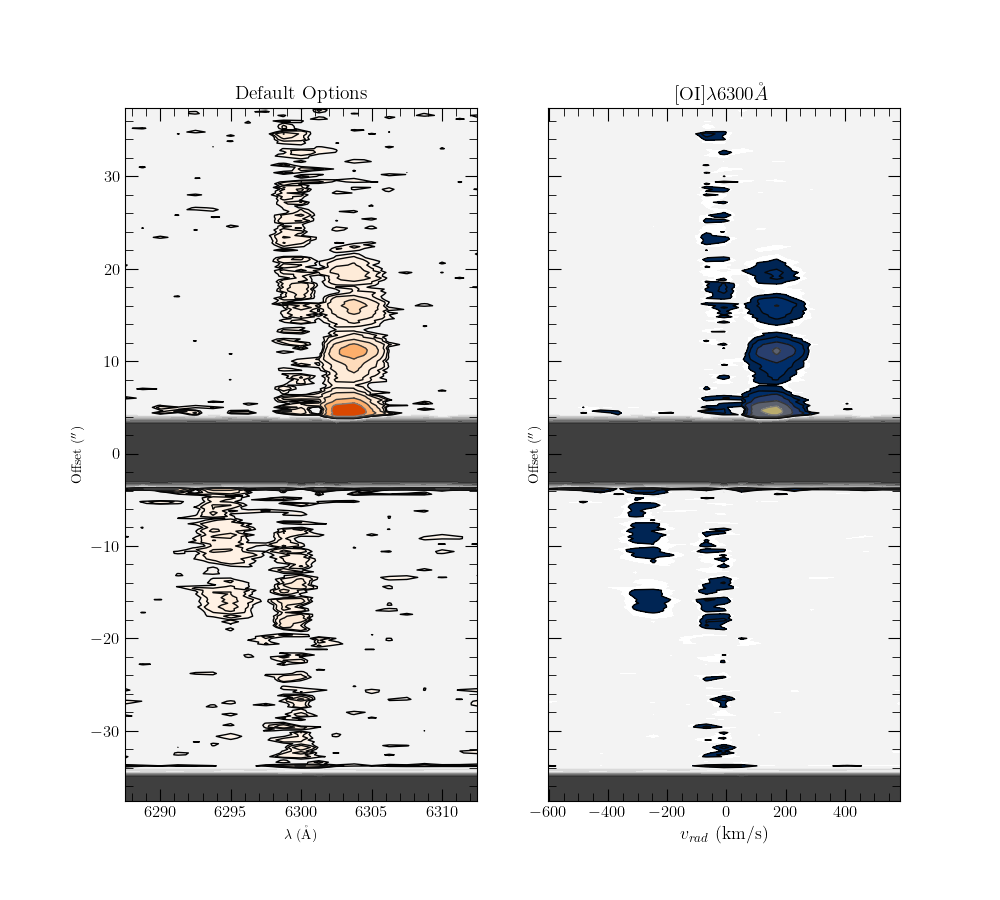

Text(0.5, 0, '$v_{rad}$ (km/s)')

In [7]:
%matplotlib notebook
from telassar.plotter import get_background_rms

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 9))

# Just use default options
oi6300.plot_contours(figure=fig, place=0, emline="Default Options") 

# customize it a bit
# calculate a background rms at a desired sigma value
nsig = get_background_rms(oi6300.data, sigma=5.)

# set increasing levels in sqrt(2) increments
levels = [nsig * np.sqrt(2)**i for i in range(2, 13, 2)]
# print(levels)

# we can also define our own extent, using our radial velocity array
y1, y2 = oi6300.position.get_range()
x1, x2 = oi_vrad
extent = {'extent' : [x1, x2, y1, y2]}
oi6300.plot_contours(figure=fig, 
                     place=1,
                     levels1=levels,
                     cmaps=['gist_gray', 'cividis', 'gray'],
                     plt_kws=extent,
                     emline="OI6300",
)

# just fix the x-axis label
axes[1].set_xlabel(r"$v_{rad}$ (km/s)", fontsize=13)

## Profiles & Fitting routines

We can also take a cut across a spatial or spectral pixel (or pixels) to look at linear profiles, using either `spatial_profile()` or `spectral_profile()` class methods. If we plot this, it is interactive so we can click on a point to save it as a coordinate. This can be passed to the fitter and a profile can be plotted as well. The fitter can be called separately with the `Modeller` class, or it can be called directly from the `SpecLine` or `SpatLine` instance. 

In cases where there are strong negative residuals, we can also mask values below some threshold to tidy up our plot and fit the data more reliably. For this, we will get the median and the background rms, and subtract an rms factor from the median to get a lower threshold.

In [8]:
median = oi6300.median()
sig = get_background_rms(oi6300.data, sigma=3)
thresh = median - (4.5 * sig)

oi6300.data[oi6300.data < thresh] = np.ma.masked

In [10]:
%matplotlib notebook

spatial_cut = oi6300.spatial_profile(
    arc=[-1., oi6300.position.get_stop()], 
    wave=[6302, 6306], 
    spat_unit=True, 
    spec_unit=True
)

# spatial_cut.plot()

spatial_cut.info()

[INFO] SpatLine (no name)
[INFO] Data shape: (193) (arcsec, nounit)
[INFO] Spatial Offset: min: -1.0" max: 37.4" step: 0.200"
[INFO] No spectral coordinates installed


In this instance we have clicked 5 peaks, and their `(offset, flux)` coordinates are stored in the `spatial_cut` instance. The fitter is designed to be able to fit multiple peaks, so we can pass the model names as single-character keys, i.e. `g` for a Gaussian model, `l` for a Lorentzian model, or `v` for a Voigt profile. These are all passed to `lmfit`. I haven't quite figured out how to really optimize it, so it is likely that the `model_list` will need to be tested and possibly run a few times to get it to work "correctly."

In [36]:
# model
# coords = spatial_cut._coords
for offset, flux in coords:
    print("%0.4g \t %0.4g" % (offset, flux))

4.8 	 1647
8.4 	 205.1
11.2 	 752.1
16 	 357.6
19.2 	 179.8


<IPython.core.display.Javascript object>


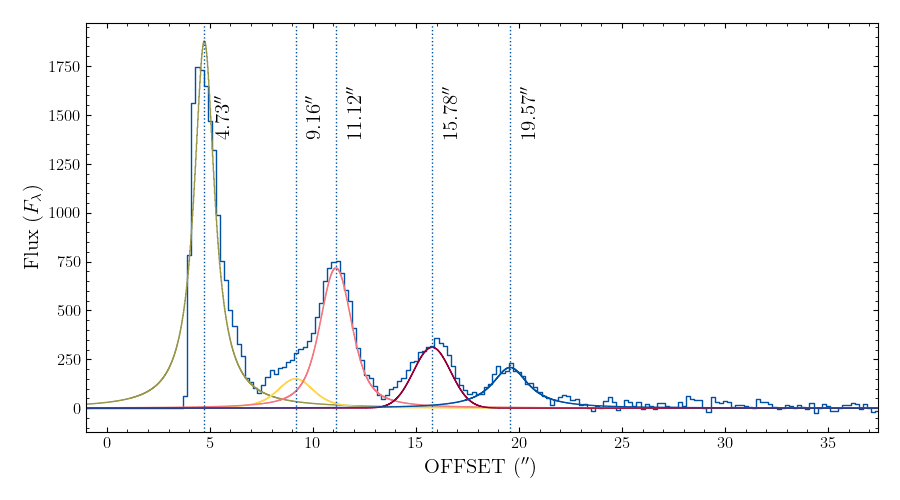

In [40]:
%matplotlib notebook
from telassar.fitter import Modeller

model_list = ['l', 'v', 'v', 'g', 'l']
model = Modeller(spatial_cut)

result = model.fit_model(model_list, plot=True)

# print(model.info())
# for key, val in model.fit_result.params.items():
#     if key.endswith('center'):
#         print(val)

We can view very basic information about these fits (i.e., centroid, FWHM, and sigma) with `model.get_info()`, which returns an array. Alternatively, we can call `model.info()` for a prettier print. If we want the full statistical output of the fits, we can call the `lmfit.model.ModelResult` contained in the `model.fit_result` attribute.

In [53]:
# get the basic information as an array
print(model.get_info())

[[ 4.73373976  1.20243889  0.60121944]
 [ 9.15951299  2.09539027  0.58184426]
 [11.1188408   1.83769719  0.5102885 ]
 [15.78280278  2.1178269   0.89935829]
 [19.57256567  2.14423996  1.07211998]]


In [55]:
# print it prettily
model.info()

[INFO] Spatial Offset: min: -1.0" max: 37.4" step: 0.200"
[INFO] Fit Info (in arcsec)
[INFO] Centroid     FWHM
[INFO]     4.73      1.2
[INFO]     9.16      2.1
[INFO]    11.12     1.84
[INFO]    15.78     2.12
[INFO]    19.57     2.14


In [68]:
# get the full output of the lmfit procedure
print(model.fit_result.fit_report(min_correl=0.8))

[[Model]]
    ((((Model(lorentzian, prefix='m0') + Model(voigt, prefix='m1')) + Model(voigt, prefix='m2')) + Model(gaussian, prefix='m3')) + Model(lorentzian, prefix='m4'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 361
    # data points      = 193
    # variables        = 15
    chi-square         = 1366132.54
    reduced chi-square = 7674.90191
    Akaike info crit   = 1740.90720
    Bayesian info crit = 1789.84755
[[Variables]]
    m0amplitude:  3546.77048 +/- 114.945126 (3.24%) (init = 1812.216)
    m0center:     4.73373976 +/- 0.01832784 (0.39%) (init = 4.8)
    m0sigma:      0.60121944 +/- 0.02697604 (4.49%) (init = 5)
    m0fwhm:       1.20243889 +/- 0.05395209 (4.49%) == '2.0000000*m0sigma'
    m0height:     1877.80380 +/- 57.1484634 (3.04%) == '0.3183099*m0amplitude/max(1e-15, m0sigma)'
    m1amplitude:  419.086532 +/- 369.474024 (88.16%) (init = 225.6468)
    m1center:     9.15951299 +/- 0.65487029 (7.15%) (init = 8.4)
    m1sigma:      0.581

In [ ]:
%matplotlib notebook
spatial_cut.fit_model(model_list=model_list, coords=coords)

In [130]:
from scipy.integrate import trapezoid

trapezoid(d, dx=0.2)
np.trapz(d, dx=0.2)


6689.362118769321

In [154]:
np.trapz(y=d, x=x)

6695.6760905621695

In [47]:
dist = spatial_cut.position.pix2offset()
data = spatial_cut.data.copy()
# data.mask = ~np.isfinite(data.data)
ndata = data.compressed()
ndist = np.compress(data, dist)


In [48]:
np.trapz(y=ndata, x=ndist)#, dx=np.diff(ndist)[0])

6689.362118769416

In [52]:
np.trapz(y=data,x=dist, axis=0)

6689.362118769416

In [38]:
spatial_cut.integrate()

6694.482215541013

In [40]:
spatial_cut.data.sum()


33472.411077704586

In [ ]:
ndata = 